In [1]:
import scipy
from scipy.interpolate import griddata
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import numpy as np
import cmocean
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = 'notebook'
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

In [2]:
def convertDiffuseFile(fileInName):   
    fileContents = scipy.io.loadmat(fileInName)
    covisDict = {}
    covisDict['header'] = fileContents['__header__'].decode('utf-8')
    covisDict['version'] = fileContents['__version__']
    covisDict['globals'] = fileContents['__globals__']
    covis = fileContents['covis'][0][0]
    for name in covis.dtype.names:
        covisDict[name] = covis[name]
    
    print(f'{fileInName} has been converted')
    return covisDict

In [3]:
def convertImagingFile(fileInName):
    fileContents = scipy.io.loadmat(fileInName)
    covisDict = {}
    covisDict['header'] = fileContents['__header__'].decode('utf-8')
    covisDict['version'] = fileContents['__version__']
    covisDict['globals'] = fileContents['__globals__']
    covis = fileContents['imaging'][0][0]
    for name in covis.dtype.names:
        covisDict[name] = covis[name]
    
    print(f'{fileInName} has been converted')
    return covisDict

In [4]:
def readCoords2D(fileInName):
    covisDict = convertDiffuseFile(fileInName)
    wList = [w for w in covisDict['grid'][0][0][0]['w']]
    xList = [x for x in covisDict['grid'][0][0][0]['x']]
    yList = [y for y in covisDict['grid'][0][0][0]['y']]
    vList = [v for v in covisDict['grid'][0][0][0]['v']]
    coordsDict = {'xList': xList, 'yList': yList, 'vList': vList, 'wList': wList}
    return coordsDict

In [5]:
def readCoords3D(fileInName, dataVal):
    covisDict = convertImagingFile(fileInName)
    xList = [x for x in covisDict['grid'][0][0]['x']]
    yList = [y for y in covisDict['grid'][0][0]['y']]
    zList = [z for z in covisDict['grid'][0][0]['z']]
    vList = [v for v in covisDict['grid'][0][0][f'{dataVal}']]
    wList = [w for w in covisDict['grid'][0][0]['w']]
    coordsDict = {'xList': xList, 'yList': yList, 'zList': zList, 'vList': vList, 'wList': wList}
    return coordsDict

In [6]:
def readCoordsBathymetry(bathyFileInName, diffuseFileInName):
    bathyDict = convertDiffuseFile(bathyFileInName)
    diffuseDict = convertDiffuseFile(diffuseFileInName)
    xList = [x for x in bathyDict['grid'][0][0]['x']]
    yList = [y for y in bathyDict['grid'][0][0]['y']]
    zList = [z for z in bathyDict['grid'][0][0]['v']]
    vList = [v for v in diffuseDict['grid'][0][0][0]['v']]
    coordsDict = {'xList': xList, 'yList': yList, 'zList': zList, 'vList': vList}
    return coordsDict

In [7]:
def removeZeroSlices(arr, axis, coordsDict):
    red_axes = tuple(i for i in range(arr.ndim) if i != axis)
    mask = np.any(arr, axis = red_axes)
    slicing = tuple(slice(None) if i != axis else mask for i in range(arr.ndim))
    for key, value in coordsDict.items():
        coordsDict[key] = value[slicing]
    return coordsDict

In [8]:
def removeAllZeros(coordsDict):
    mask = coordsDict['vList'] > 0
    coordsDict = {key: coordsDict[key][mask] for key in coordsDict.keys()}
    return coordsDict

In [9]:
def createNDArray(coordsDict, dim):
    xmin, xmax = coordsDict['xList'].min(), coordsDict['xList'].max()
    ymin, ymax = coordsDict['yList'].min(), coordsDict['yList'].max()
    zmin, zmax = 0, 0
    minmaxDict = {'x': (xmin, xmax), 'y': (ymin, ymax)}

    if dim == 3:
        zmin, zmax = coordsDict['zList'].min(), coordsDict['zList'].max()
        minmaxDict['z'] = (zmin, zmax)
    
    dimDict = {}
    for key, value in minmaxDict.items():
        dimDict[key] = int((value[1] - value[0]) * 4 + 1)

    if dim == 2:
        for key, value in coordsDict.items():
            coordsDict[key] = value.reshape(dimDict['x'], dimDict['y'])
    elif dim == 3:
        for key, value in coordsDict.items():
            coordsDict[key] = value.reshape(dimDict['x'], dimDict['y'], dimDict['z'])

    return coordsDict

In [10]:
def createCoordsOfInterest(fileInName, opt1, opt2 = 'Ia', bathyFile = r'matFiles\covis_bathy_2019b.mat'):
    if opt1 == 2:
        coordsDict = readCoords2D(fileInName)
        coordsDict = {key: np.array(coordsDict[key]) for key in coordsDict.keys()}

        vList = coordsDict['vList']
        for i in [0, 1, 2]:
            coordsDict = removeZeroSlices(vList, i, coordsDict)

        coordsDict = {key: np.concatenate(coordsDict[key]).flatten() for key in coordsDict.keys()}

    elif opt1 == 3:
        coordsDict = readCoords3D(fileInName, opt2)
        coordsDict = {key: np.array(coordsDict[key]) for key in coordsDict.keys()}

        vList = coordsDict['vList']
        for i in [0, 1, 2]:
            coordsDict = removeZeroSlices(vList, i, coordsDict)

        coordsDict = {key: np.concatenate(coordsDict[key]).flatten() for key in coordsDict.keys()}

    elif opt1 == 4:
        coordsDict = readCoordsBathymetry(bathyFile, fileInName)
        coordsDict = {key: np.array(coordsDict[key]) for key in coordsDict.keys()}
        coordsDict = {key: np.concatenate(coordsDict[key]).flatten() for key in coordsDict.keys()}

        coordsDict['vList'] = coordsDict['vList'].reshape(121, 121)[:,:101]
        coordsDict['vList'] = np.concatenate(coordsDict['vList']).flatten()
        coordsDict['zList'] = np.nan_to_num(coordsDict['zList'])
    
    return coordsDict

In [11]:
def plotDiffuse2DV1(fileInName):
    coordsOfInterest = createCoordsOfInterest(fileInName, 2)
    plt.figure(figsize=(8, 6))

    coordsOfInterest = removeAllZeros(coordsOfInterest)
    coordsOfInterest['vList'] = np.log10(coordsOfInterest['vList'])
    max = np.floor(np.amax(coordsOfInterest['vList']))
    min = np.ceil(np.amin(coordsOfInterest['vList']))
    scatter = plt.scatter(coordsOfInterest['xList'], coordsOfInterest['yList'], c = coordsOfInterest['vList'], cmap = 'viridis')

    cbar = plt.colorbar(scatter)
    cbar_ticks = np.arange(min, max + 1, 1)
    cbar.set_ticks(cbar_ticks)
    cbar.set_label('Data Values')

    plt.xlabel('East of COVIS (m)')
    plt.ylabel('North of COVIS (m)')
    plt.title(fileInName.split('\\')[-1])
    plt.show()


matFiles\COVIS-20230701T003002-diffuse1.mat has been converted


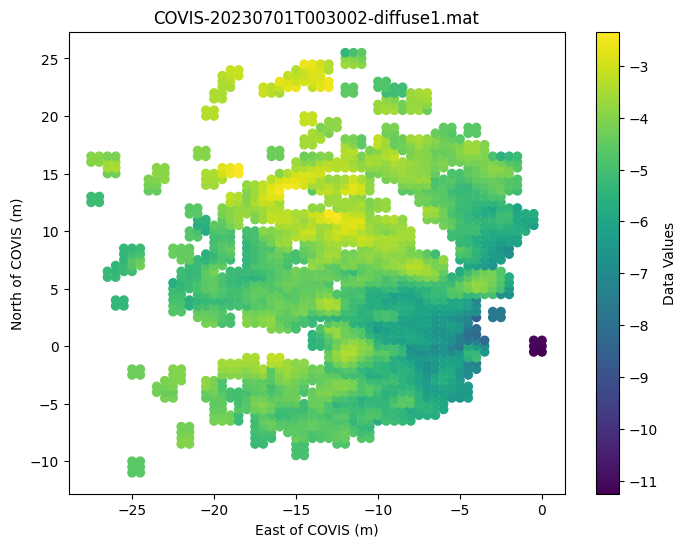

In [12]:
plotDiffuse2DV1(r'matFiles\COVIS-20230701T003002-diffuse1.mat')

In [ ]:
def plotFullImaging3DV1(fileInName, opt2):
    coordsOfInterest = createCoordsOfInterest(fileInName, 3, opt2)
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    coordsOfInterest = removeAllZeros(coordsOfInterest)
    coordsOfInterest['vList'] = np.log10(coordsOfInterest['vList'])
    max = np.floor(np.amax(coordsOfInterest['vList']))
    min = np.ceil(np.amin(coordsOfInterest['vList']))
    scatter = ax.scatter(coordsOfInterest['xList'], coordsOfInterest['yList'], coordsOfInterest['zList'], c = coordsOfInterest['vList'], cmap = 'viridis')
    
    cbar = plt.colorbar(scatter)
    cbar.set_label(f'{opt2} Values')
    cbar_ticks = np.arange(min, max + 1, 1)
    cbar.set_ticks(cbar_ticks)

    ax.set_xlabel('East of COVIS (m)')
    ax.set_ylabel('North of COVIS (m)')
    ax.set_zlabel('Z Axis')
    ax.set_title(f'3D Scatter Plot (Logarithmic scale, {opt2})')

    plt.show()

In [ ]:
plotFullImaging3DV1(r'matFiles\COVIS-20230101T000002-imaging1.mat', 'Ia')
plotFullImaging3DV1(r'matFiles\COVIS-20230101T000002-imaging1.mat', 'Id')
plotFullImaging3DV1(r'matFiles\COVIS-20230101T000002-imaging1.mat', 'Ia_filt')
plotFullImaging3DV1(r'matFiles\COVIS-20230101T000002-imaging1.mat', 'Id_filt')
plotFullImaging3DV1(r'matFiles\COVIS-20230101T000002-imaging1.mat', 'Kp')

In [ ]:
def plotFullImaging3DV2(fileInName, opt2):
    coordsOfInterest = createCoordsOfInterest(fileInName, 3, opt2)
    z = coordsOfInterest['zList']
    x = coordsOfInterest['xList']
    y = coordsOfInterest['yList']
    points = np.array( (z.flatten(), x.flatten(), y.flatten()) ).T
    values = coordsOfInterest['vList'].flatten()
    Z, X, Y = np.mgrid[z.min():z.max():20j, x.min():x.max():50j, y.min():y.max():50j]
    newdata = griddata( points, values, (Z,X,Y) )

    # coordsOfInterest['vList'] = np.log10(coordsOfInterest['vList'])
    # max = np.ceil(np.amax(coordsOfInterest['vList']))
    # min = np.floor(np.amin(coordsOfInterest['vList']))

    fig = go.Figure(data=go.Isosurface(
        x = X.flatten(),
        y = Y.flatten(),
        z = Z.flatten(),
        value = newdata.flatten(),
        colorscale  = 'Viridis',
        isomin = .0001,
        isomax = .00001,
        surface_count=2
    ))
    
    fig.update_layout(
        title=f'3D Isosurface Plot (Logarithmic scale, {opt2})',
        scene=dict(
            xaxis_title='East of COVIS (m)',
            yaxis_title='North of COVIS (m)',
            zaxis_title='Z Axis'
        ),
        coloraxis_colorbar=dict(
            title=f'{opt2} Values',
            tickvals=np.linspace(min, max, num=5),
            ticktext=[f'{val:.2e}' for val in np.linspace(min, max, num=5)]
        )
    )
    
    fig.show()


In [ ]:
plotFullImaging3DV2(r'matFiles\COVIS-20230101T000002-imaging1.mat', 'Ia')

In [ ]:
cd = createCoordsOfInterest(r'matFiles\COVIS-20230101T000002-imaging1.mat', 3, 'Ia')
cd = createNDArray(cd, 3)
x = cd['xList']
y = cd['yList']
z = cd['zList']
values = cd['vList']
values = values.flatten()
mask = values == 0
data_with_nan = np.where(mask, np.nan, values)
values = np.log10(data_with_nan)
values = np.where(np.isnan(values), 0, values)


fig = go.Figure(data=go.Isosurface(
    x = x.flatten(),
    y = y.flatten(),
    z = z.flatten(),
    value = values.flatten(),
    colorscale  = 'Reds',
    isomin = 10e-9,
    isomax = np.max(values[values != 0]),
    surface_count = 5,
    opacity = .5
))

fig.show()

In [ ]:
def plotDiffuseBathymetryV1(fileInName, bathyFile = r'matFiles\covis_bathy_2019b.mat'):
    coordsOfInterest = createCoordsOfInterest(fileInName, 4, bathyFile)
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    coordsOfInterest = removeAllZeros(coordsOfInterest)
    coordsOfInterest['vList'] = np.log10(coordsOfInterest['vList'])
    max = np.floor(np.amax(coordsOfInterest['vList']))
    min = np.ceil(np.amin(coordsOfInterest['vList']))

    scatter = ax.scatter(coordsOfInterest['xList'], coordsOfInterest['yList'], coordsOfInterest['zList'], c = coordsOfInterest['vList'], cmap = 'cmo.deep_r')

    cbar = plt.colorbar(scatter)
    cbar.set_label('Values')
    cbar_ticks = np.arange(min, max + 1)
    cbar.set_ticks(cbar_ticks)

    ax.set_xlabel('East of COVIS (m)')
    ax.set_ylabel('North of COVIS (m)')
    ax.set_zlabel('Depth Relative to COVIS (m)')
    ax.set_title(f'Diffuse on Bathymetry')
    
    plt.show()

In [ ]:
def plotDiffuseBathymetryV2(fileInName, opt2, bathyFile = r'matFiles\covis_bathy_2019b.mat'):
    coordsOfInterest = createCoordsOfInterest(fileInName, 4, bathyFile)
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    if opt2 == 'zList':
        param = 'height'
        cmapopt = 'cmo.deep_r'
    elif opt2 == 'vList':
        param = 'data values'
        cmapopt = 'viridis'

    vList = coordsOfInterest['vList']
    for i in [0, 1, 2]:
        coordsOfInterest = removeZeroSlices(vList, i, coordsOfInterest)

    x = coordsOfInterest['xList']
    y = coordsOfInterest['yList']

    xi = np.linspace(np.min(x), np.max(x), 100)
    yi = np.linspace(np.min(y), np.max(y), 100)
    xi, yi = np.meshgrid(xi, yi)
    zi = griddata((x, y), coordsOfInterest[opt2], (xi, yi), method='linear')

    surf = ax.plot_surface(xi, yi, zi, cmap = cmapopt, edgecolor = 'none')

    cbar = plt.colorbar(surf)
    cbar.set_label('Depth (m)')

    ax.set_xlabel('East of COVIS (m)')
    ax.set_ylabel('North of COVIS (m)')
    ax.set_zlabel('Depth (m)')
    ax.set_title(f'Bathymetry, {param}')

    plt.show()


In [34]:
def plotDiffuseBathymetryV3(fileInName, opt2, bathyFile = r'matFiles\covis_bathy_2019b.mat'):
    coordsOfInterest = createCoordsOfInterest(fileInName, 4, bathyFile)
    plt.figure(figsize=(12, 8))

    x = coordsOfInterest['xList']
    y = coordsOfInterest['yList']
    data = coordsOfInterest[opt2]
    
    
    if opt2 == 'zList':
        param = 'height'
    elif opt2 == 'vList':
        param = 'data values'
        data = np.ma.masked_where(data == 0, data)
        mask = data > 0
        data[mask] = np.log10(data[mask])
    
    indices = np.lexsort((x, y))
    x = x[indices].reshape(121, 101)
    y = y[indices].reshape(121, 101)
    data = data[indices].reshape(121, 101)

    plt.pcolormesh(x, y, data, shading = 'auto')
    plt.colorbar(label = param)

    plt.xlabel('East of COVIS (m)')
    plt.ylabel('North of COVIS (m)')
    plt.title(f'Pcolor Plot of Bathymetry, {param}')

    plt.show()

In [ ]:
plotDiffuseBathymetryV1(r'matFiles\COVIS-20230701T003002-diffuse1.mat')
plotDiffuseBathymetryV2(r'matFiles\COVIS-20230701T003002-diffuse1.mat', 'zList')
plotDiffuseBathymetryV2(r'matFiles\COVIS-20230701T003002-diffuse1.mat', 'vList')
plotDiffuseBathymetryV3(r'matFiles\COVIS-20230701T003002-diffuse1.mat', 'zList')
plotDiffuseBathymetryV3(r'matFiles\COVIS-20230701T003002-diffuse1.mat', 'vList')

In [ ]:
def splatAlongAxis(fileInName, opt2, blur, axis = 'x'):
    coordsOfInterest = createCoordsOfInterest(fileInName, 3, opt2)
    coordsOfInterest = removeAllZeros(coordsOfInterest)

    if axis == 'x':
        proj_coords = (coordsOfInterest['yList'], coordsOfInterest['zList'])
        xlabel, ylabel = 'y', 'z'
    elif axis == 'y':
        proj_coords = (coordsOfInterest['xList'], coordsOfInterest['zList'])
        xlabel, ylabel = 'x', 'z'
    elif axis == 'z':
        proj_coords = (coordsOfInterest['xList'], coordsOfInterest['yList'])
        xlabel, ylabel = 'x', 'y'
    
    coordsOfInterest['vList'] = np.log10(coordsOfInterest['vList'])

    minCoord1 = np.min(proj_coords[0])
    maxCoord1 = np.max(proj_coords[0])
    minCoord2 = np.min(proj_coords[1])
    maxCoord2 = np.max(proj_coords[1])
    
    gridSize = 500
    grid, _, _ = np.histogram2d(proj_coords[0], proj_coords[1], bins = gridSize, 
                                range=[[minCoord1, maxCoord1], [minCoord2, maxCoord2]], weights = coordsOfInterest['vList'])
    
    splatted_image = gaussian_filter(grid, sigma = blur)
    
    plt.imshow(splatted_image.T, origin='lower', cmap='inferno', 
               extent=[minCoord1, maxCoord1, minCoord2, maxCoord2])
    plt.colorbar(label='Accumulated Value')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(f'Splatting along {axis}-axis, {opt2}')
    plt.show()

In [ ]:
splatAlongAxis(r'matFiles\COVIS-20230101T000002-imaging1.mat', 'Ia', 2, 'x')
splatAlongAxis(r'matFiles\COVIS-20230101T000002-imaging1.mat', 'Ia', 2, 'y')
splatAlongAxis(r'matFiles\COVIS-20230101T000002-imaging1.mat', 'Ia', 2, 'z')